In [1]:
import numpy as np
import pandas as pd
import uwb_dataset

# import raw data
columns, data = uwb_dataset.import_from_files()

# divide CIR by RX preable count (get CIR of single preamble pulse)
# item[2] represents number of acquired preamble symbols
for item in data:
	item[15:] = item[15:]/float(item[2])

print("\nColumns :", columns.shape, sep=" ")
print("Data :", data.shape, sep=" ")
print(type(data))

./dataset/uwb_dataset_part1.csv
./dataset/uwb_dataset_part2.csv
./dataset/uwb_dataset_part3.csv
./dataset/uwb_dataset_part4.csv
./dataset/uwb_dataset_part5.csv
./dataset/uwb_dataset_part6.csv
./dataset/uwb_dataset_part7.csv

Columns : (1031,)
Data : (42000, 1031)
<class 'numpy.ndarray'>


In [2]:
cir_n = len(columns[15:])

print("Columns :", columns, sep=" ")
print("Channel Inpulse Response Count :", cir_n, sep=" ")

Columns : ['NLOS' 'RANGE' 'FP_IDX' ... 'CIR1013' 'CIR1014' 'CIR1015']
Channel Inpulse Response Count : 1016


In [3]:
df_uwb = pd.DataFrame(data=data, columns=columns)
print("Channel 2 count :", df_uwb.query("CH == 2")['CH'].count())
print("Null/NaN Data Count : ", df_uwb.isna().sum().sum())
df_uwb.head(3)

Channel 2 count : 42000
Null/NaN Data Count :  0


,NLOS,RANGE,FP_IDX,FP_AMP1,FP_AMP2,FP_AMP3,STDEV_NOISE,CIR_PWR,MAX_NOISE,RXPACC,...,CIR1006,CIR1007,CIR1008,CIR1009,CIR1010,CIR1011,CIR1012,CIR1013,CIR1014,CIR1015
0,0.0,3.90,745.0,18712.0,10250.0,11576.0,64.0,11855.0,967.0,611.0,...,0.374497,0.614765,0.245638,0.212081,0.265772,0.116779,0.397315,0.677852,0.412081,0.0
1,0.0,0.66,749.0,11239.0,6313.0,4712.0,64.0,18968.0,1133.0,447.0,...,0.192256,0.445928,0.387183,0.304406,0.249666,0.284379,0.269693,0.118825,0.137517,0.0
2,1.0,7.86,746.0,4355.0,5240.0,3478.0,60.0,14699.0,894.0,723.0,...,0.042895,0.500000,0.300268,0.233244,0.166220,0.441019,0.277480,0.128686,0.292225,0.0


In [4]:
# LOS/NLOS Count
los_count = df_uwb.query("NLOS == 0")["NLOS"].count()
nlos_count = df_uwb.query("NLOS == 1")["NLOS"].count()

print("Line of Sight Count :", los_count)
print("Non Line of Sight Count :", nlos_count)

Line of Sight Count : 21000
Non Line of Sight Count : 21000


In [5]:
# Columns CIR Extract
df_uwb_data = df_uwb[["CIR"+str(i) for i in range(cir_n)]]
print("UWB DataFrame X for Trainndarray shape : ",df_uwb_data.values.shape)
df_uwb_data.head(5)

UWB DataFrame X for Trainndarray shape :  (42000, 1016)


,CIR0,CIR1,CIR2,CIR3,CIR4,CIR5,CIR6,CIR7,CIR8,CIR9,...,CIR1006,CIR1007,CIR1008,CIR1009,CIR1010,CIR1011,CIR1012,CIR1013,CIR1014,CIR1015
0,0.173154,0.418792,0.444295,0.189262,0.214765,0.655034,0.261745,0.193289,0.159732,0.259060,...,0.374497,0.614765,0.245638,0.212081,0.265772,0.116779,0.397315,0.677852,0.412081,0.000000
1,0.156208,0.217623,0.265688,0.181575,0.189586,0.242991,0.477971,0.164219,0.373832,0.415220,...,0.192256,0.445928,0.387183,0.304406,0.249666,0.284379,0.269693,0.118825,0.137517,0.000000
2,0.580429,0.321716,0.312332,0.108579,0.191689,0.678284,0.159517,0.364611,0.332440,0.312332,...,0.042895,0.500000,0.300268,0.233244,0.166220,0.441019,0.277480,0.128686,0.292225,0.000000
3,0.621333,0.329333,0.542667,0.300000,0.372000,0.092000,0.524000,0.581333,0.385333,0.225333,...,0.336000,0.230667,0.264000,0.213333,0.578667,0.529333,0.386667,0.206667,0.456000,0.341333
4,0.347185,0.320375,0.076408,0.025469,0.117962,0.293566,0.536193,0.202413,0.131367,0.556300,...,0.206434,0.280161,0.324397,0.396783,0.116622,0.238606,0.420912,0.331099,0.391421,0.343164


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

import time
import random

import uwb_dataset

print("Pytorch Version :", torch.__version__)  # Pytorch Version : 1.7.1+cu110
writer = SummaryWriter('runs/UWB_CIR_Classfication')

%matplotlib inline

Pytorch Version : 2.0.1+cpu


In [7]:
# random seed
random_seed = 42

num_epoch = 10
batch_size = 64
in_channels = 1
num_classes = 2
num_layers = 2
fully_connected = 128

lr = 0.001
weight_decay = 0.0

# Parameters
view_train_iter = 50
view_val_iter = 5
save_point = 0.90

In [8]:
def torch_random_seed(on_seed=False, random_seed=1):
    if on_seed:
        torch.manual_seed(random_seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

        np.random.seed(random_seed)
        random.seed(random_seed)
        
torch_random_seed(on_seed=True, random_seed=random_seed)

In [9]:
def get_clf_eval(y_true, y_pred, average='weighted'):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average=average)
    recall = recall_score(y_true, y_pred, average=average)
    f1 = f1_score(y_true, y_pred, average=average)

    return accuracy, precision, recall, f1

In [10]:
# sklearn의 train_test_split은 stratify 파라미터를 통해 Label의 비율을 유지하면서 Split
x_train, x_test, y_train, y_test = train_test_split(df_uwb_data.values, df_uwb['NLOS'].values, test_size=0.1, random_state=42, stratify=df_uwb['NLOS'].values)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=random_seed, stratify=y_train)

print("x_train shape :", x_train.shape, y_train.shape)
print("x_val shape :", x_val.shape, y_val.shape)
print("x_test shape :", x_test.shape, y_test.shape)

x_train shape : (34020, 1016) (34020,)
x_val shape : (3780, 1016) (3780,)
x_test shape : (4200, 1016) (4200,)


In [11]:
print("Train NLOS 0 count :", len(y_train[y_train==0]))
print("Train NLOS 1 count :", len(y_train[y_train==1]))
print("Validation NLOS 0 count :", len(y_val[y_val==0]))
print("Validation NLOS 1 count :", len(y_val[y_val==1]))
print("Test NLOS 0 count :", len(y_test[y_test==0]))
print("Test NLOS 0 count :", len(y_test[y_test==1]))

Train NLOS 0 count : 17010
Train NLOS 1 count : 17010
Validation NLOS 0 count : 1890
Validation NLOS 1 count : 1890
Test NLOS 0 count : 2100
Test NLOS 0 count : 2100


In [12]:
def generating_loader(x_data, y_data, batch_size=batch_size, shuffle=True, drop_last=True):
    # preprocessing x_data
    x_data = np.expand_dims(x_data, axis=1)
    x_tensor = torch.tensor(x_data, dtype=torch.float32)
    # preprocessing y_data
    y_tensor = torch.tensor(y_data, dtype=torch.long).view(-1)

    return DataLoader(TensorDataset(x_tensor, y_tensor), batch_size=batch_size, shuffle=shuffle, drop_last=drop_last)

In [13]:
trainloader = generating_loader(x_train, y_train, batch_size=batch_size, shuffle=True, drop_last=True)
validationloader = generating_loader(x_val, y_val, batch_size=batch_size, shuffle=False, drop_last=True)
testloader = generating_loader(x_val, y_val, batch_size=batch_size, shuffle=False, drop_last=True)

In [14]:
for x, label in trainloader:
    print(x.shape, label.shape)
    break

torch.Size([64, 1, 1016]) torch.Size([64])


In [15]:
class CNN_LSTM(nn.Module):
    def __init__(self, in_channels, out_channels, batch_size, num_layers, fully_connected, device):
        super(CNN_LSTM, self).__init__()
        self.batch_size = batch_size
        self.conv1d_layer = nn.Sequential(
            nn.Conv1d(in_channels=in_channels, out_channels=10, kernel_size=4, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv1d(in_channels=10, out_channels=20, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
        ) 
        self.lstm = nn.LSTM(input_size = 504, 
                            hidden_size = 32, 
                            num_layers = num_layers,
                            bias = False,
                            dropout = 0.5,
                            bidirectional = True,
                            batch_first=True)

        self.hidden_state, self.cell_state = self.init_hidden()
        
        self.bn2 = nn.BatchNorm1d(20)
        self.bn0 = nn.BatchNorm1d(64)
        self.bn1 = nn.BatchNorm1d(128)

        self.fc_layer = nn.Linear(64, 128)
        self.relu = nn.ReLU()
        self.fc_layer_class = nn.Linear(128, out_channels)


    def init_hidden(self):
        hidden_state = torch.zeros(num_layers*2, self.batch_size, 32).to(device)
        cell_state = torch.zeros(num_layers*2, self.batch_size, 32).to(device)

        return hidden_state, cell_state
        
    def forward(self, x):
        x = self.conv1d_layer(x)
        x, _ = self.lstm(x,(self.hidden_state, self.cell_state))
        x = x[:, -1 :].view(x.size(0), -1)
        x = self.bn0(x)
        x = self.fc_layer(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.fc_layer_class(x)
        x = self.relu(x)

        return x

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CNN_LSTM(
    in_channels=in_channels,\
    device=device,\
    out_channels=num_classes,\
    batch_size=batch_size,\
    fully_connected=fully_connected,\
    num_layers=num_layers).to(device)
loss_function = nn.CrossEntropyLoss()  
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)  # optimizer

# tensorboard
images, labels = next(iter(trainloader))
writer.add_graph(model, images.to(device))

# lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer=optimizer, milestones=[int(num_epoch * 0.5), int(num_epoch * 0.75)], gamma=0.1, last_epoch=-1)

In [17]:
start = time.time()

correct = 0
total = 0
train_acc = []
tmp_acc = 0
loss_arr = []

print("*Train Start!!*")
if torch.cuda.device_count() == True:
    print("epoch : {}, learing rate : {}, device : {}".format(num_epoch, lr, torch.cuda.get_device_name(0)))
    print("Model : {}".format(model._get_name()))
    print("Loss function : {}".format(loss_function._get_name()))
    print("Optimizer : {}".format(str(optimizer).replace("\n", " ").replace("     ", ", ")))
else:
    print("epoch : {}, learing rate : {}, device : {}".format(num_epoch, lr, device))
    print("Model : {}".format(model._get_name()))
    print("Loss function : {}".format(loss_function._get_name()))
    print("Optimizer : {}".format(str(optimizer).replace("\n", " ").replace("     ", ", ")))
print("*"*100)

# train
for epoch in range(num_epoch):
    epoch += 1
    for train_iter, (train_x, train_y_true) in enumerate(trainloader):
        model.train()  # Train mode
        model.zero_grad()  # model zero initialize
        optimizer.zero_grad()  # optimizer zero initialize
        

        train_x, train_y_true = train_x.to(device), train_y_true.to(device)  # device(gpu)
        train_y_pred = model.forward(train_x)  # forward
        loss = loss_function(train_y_pred, train_y_true)  # loss function
        loss.backward()  # backward
        optimizer.step()  # optimizer
        _, pred_index = torch.max(train_y_pred, 1)
        
        if train_iter % view_train_iter == 0:
            loss_arr.append(loss.item())
            total += train_y_true.size(0)  # y.size(0)
            correct += (pred_index == train_y_true).sum().float()  # correct
            tmp_acc = correct / total  # accuracy
            train_acc.append(tmp_acc)

            writer.add_scalar("Loss/train", loss, epoch)
            writer.add_scalar("Accuracy/train",tmp_acc, epoch)

            print("[Train] ({}, {}) Time={:.2f}[s], loss = {:.5f}, Accuracy = {:.4f}, lr={:.6f}".format(epoch, train_iter, time.time()-start, loss.item(), tmp_acc, optimizer.param_groups[0]['lr']))
    # lr_scheduler.step()
    # validation 
    if epoch % view_val_iter == 0: 
        val_acc_tmp, val_precision_tmp, val_recall_tmp, val_f1_tmp = [], [], [], []
        val_acc_result, val_precision_result, val_recall_result, val_f1_result = [], [], [], []
        val_time = time.time()
        for val_iter, (val_x, val_y_true) in enumerate(validationloader):
            model.eval()
            val_x, val_y_true = val_x.to(device), val_y_true.to(device)  # device(gpu)
            val_y_pred = model.forward(val_x)  # forward
            _, val_pred_index = torch.max(val_y_pred, 1)

            val_pred_index_cpu = val_pred_index.cpu().detach().numpy()
            val_y_true_cpu = val_y_true.cpu().detach().numpy()
            
            val_acc, val_precision, val_recall, val_f1 = get_clf_eval(val_y_true_cpu, val_pred_index_cpu)

            val_acc_tmp.append(val_acc), val_acc_result.append(val_acc)
            val_precision_tmp.append(val_precision), val_precision_result.append(val_precision)
            val_recall_tmp.append(val_recall), val_recall_result.append(val_recall)
            val_f1_tmp.append(val_f1), val_f1_result.append(val_f1)

        val_acc_mean = sum(val_acc_tmp, 0.0)/len(val_acc_tmp)
        val_precision_mean = sum(val_precision_tmp, 0.0)/len(val_precision_tmp)
        val_recall_mean = sum(val_recall_tmp, 0.0)/len(val_recall_tmp)
        val_f1_mean = sum(val_f1_tmp, 0.0)/len(val_f1_tmp)

        print("-"*100)
        print("|  Validation {:.2f}[s], Accuracy : {:.4f}, Precision : {:.4f}, Recall : {:.4f}, F1 Score : {:.4f}   |".format(
            time.time()-val_time, val_acc_mean, val_precision_mean, val_recall_mean, val_f1_mean))
        print("-"*100)
        if val_acc_mean >= save_point:
            epoch_str = str(epoch)
            lr_str = str(lr)
            batch_str= str(batch_size)
            acc_str= str((int(val_acc_mean*100)))
            model_name = "["+model._get_name()+"](epoch-"+epoch_str+")-"+"(init_lr-"+lr_str+")-"+"(batch-"+batch_str+")-"+"(acc-"+acc_str+").pt"
            save_path = os.path.join(path, dir_ ,model_name)
            parameters = {'epoch' : epoch, 'model_state_dict' : model.state_dict(), 'optimizer_state_dict' : optimizer.state_dict(), 'loss' : loss}
            torch.save(parameters, save_path)
            print('[INFO] Model Saved : '+ save_path)
writer.flush()
writer.close()

*Train Start!!*
epoch : 10, learing rate : 0.001, device : cpu
Model : CNN_LSTM
Loss function : CrossEntropyLoss
Optimizer : Adam ( Parameter Group 0, amsgrad: False, betas: (0.9, 0.999), capturable: False, differentiable: False, eps: 1e-08, foreach: None, fused: None, lr: 0.001, maximize: False, weight_decay: 0.0 )
****************************************************************************************************
[Train] (1, 0) Time=0.15[s], loss = 0.73289, Accuracy = 0.5000, lr=0.001000
[Train] (1, 50) Time=2.61[s], loss = 0.65546, Accuracy = 0.5703, lr=0.001000
[Train] (1, 100) Time=4.89[s], loss = 0.45201, Accuracy = 0.6354, lr=0.001000
[Train] (1, 150) Time=7.32[s], loss = 0.38516, Accuracy = 0.6914, lr=0.001000
[Train] (1, 200) Time=9.86[s], loss = 0.43333, Accuracy = 0.7156, lr=0.001000
[Train] (1, 250) Time=12.21[s], loss = 0.39865, Accuracy = 0.7318, lr=0.001000
[Train] (1, 300) Time=14.69[s], loss = 0.42128, Accuracy = 0.7411, lr=0.001000
[Train] (1, 350) Time=17.04[s], loss

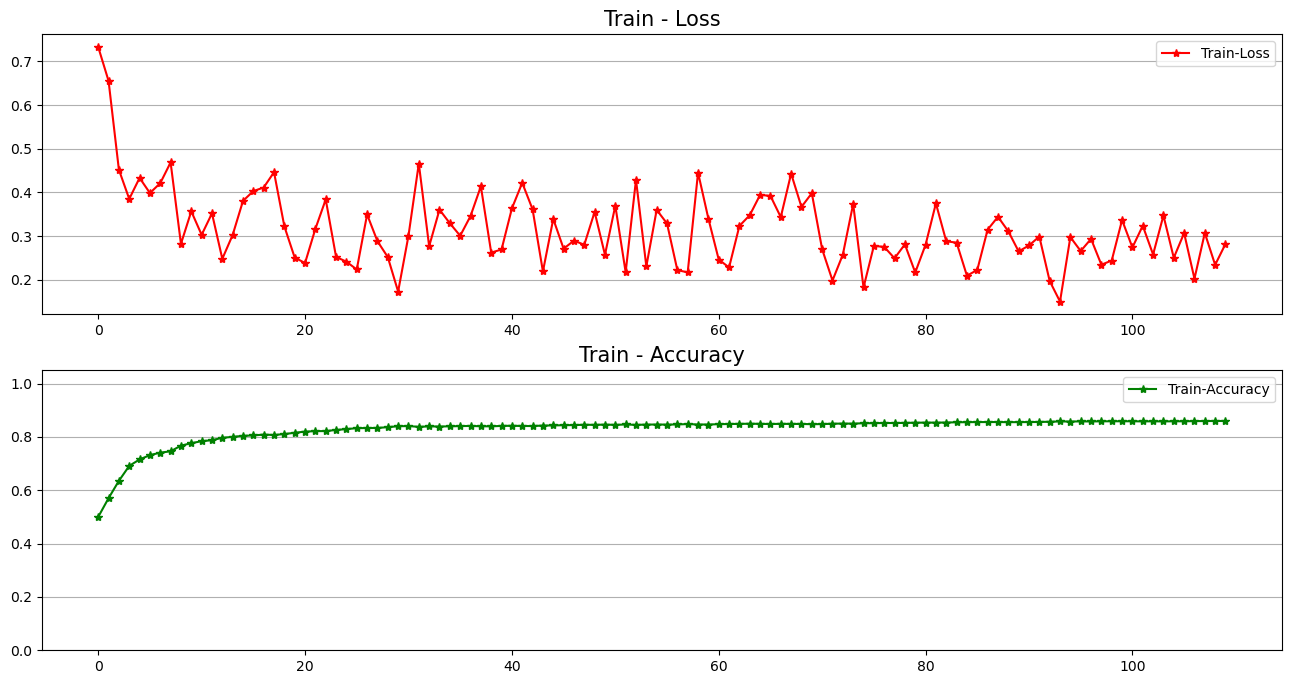

In [18]:
fig = plt.figure(figsize=[16, 8])
loss_plt = plt.subplot(2,1,1)
acc_plt = plt.subplot(2,1,2)

loss_plt.plot(loss_arr, color='red', marker="*")
loss_plt.set_title("Train - Loss", fontsize=15)
loss_plt.legend(['Train-Loss'])
loss_plt.grid(True, axis='y')

acc_plt.plot(train_acc, color='green', marker="*")
acc_plt.set_title("Train - Accuracy", fontsize=15)
acc_plt.legend(['Train-Accuracy'])
acc_plt.set_ylim((0.0, 1.05))
acc_plt.grid(True, axis='y')

plt.show()

In [19]:
test_start = time.time()

model.eval()
with torch.no_grad():
    test_acc_tmp, test_precision_tmp, test_recall_tmp, test_f1_tmp = [], [], [], []
    for test_iter, (test_x, test_y_true) in enumerate(testloader):
        test_x, test_y_true = test_x.to(device), test_y_true.to(device)
        test_y_pred = model.forward(test_x)  # forward

        _, test_pred_index = torch.max(test_y_pred, 1)

        test_pred_index_cpu = test_pred_index.cpu().detach().numpy()
        test_y_true_cpu = test_y_true.cpu().detach().numpy()
            
        test_acc, test_precision, test_recall, test_f1 = get_clf_eval(test_y_true_cpu, test_pred_index_cpu)

        test_acc_tmp.append(test_acc), test_precision_tmp.append(test_precision), test_recall_tmp.append(test_recall), test_f1_tmp.append(test_f1)

    test_acc_mean = sum(test_acc_tmp, 0.0)/len(test_acc_tmp)
    test_precision_mean = sum(test_precision_tmp, 0.0)/len(test_precision_tmp)
    test_recall_mean = sum(test_recall_tmp, 0.0)/len(test_recall_tmp)
    test_f1_mean = sum(test_f1_tmp, 0.0)/len(test_f1_tmp)
    print("[Evaluation] {:.2f}[s], Test Accuracy : {:.4f}, Precision : {:.4f}, Recall : {:.4f}, F1 Score : {:.4f}".format(
        time.time()-test_start, test_acc_mean, test_precision_mean, test_recall_mean, test_f1_mean))
    print("[Model Performance] Model Performance : {:.5f}".format(test_acc_mean))

[Evaluation] 1.36[s], Test Accuracy : 0.8755, Precision : 0.8850, Recall : 0.8755, F1 Score : 0.8748
[Model Performance] Model Performance : 0.87553


In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Train the model on the training set
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(x_train, y_train)

# Evaluate on the validation set
val_predictions = rf_classifier.predict(x_val)
val_accuracy = accuracy_score(y_val, val_predictions)
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Evaluate on the test set
test_predictions = rf_classifier.predict(x_test)
test_accuracy = accuracy_score(y_test, test_predictions)
print(f"Test Accuracy: {test_accuracy:.4f}")

Validation Accuracy: 0.8296
Test Accuracy: 0.8267


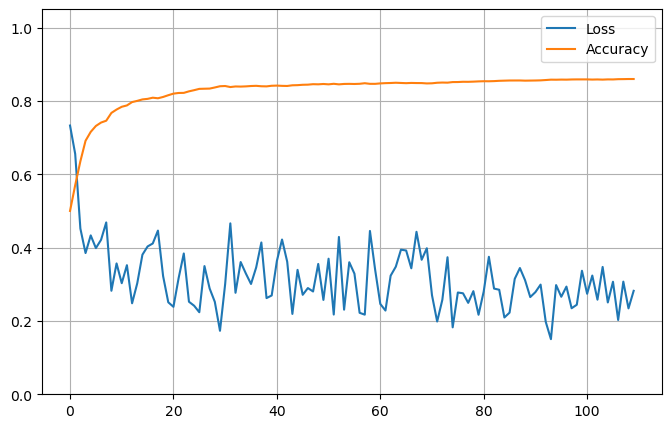

./[plot] CNN_LSTM_layer2.pdf


In [21]:
f = plt.figure(figsize=[8, 5])
f.set_facecolor("white")

plt.style.use(['default'])
plt.plot(loss_arr)
plt.plot(train_acc)


plt.legend(['Loss', 'Accuracy'])
plt.ylim((0.0, 1.05))
plt.grid(True)
plt.show()
print("./"+"[plot] "+model._get_name()+"_"+'layer'+str(num_layers)+".pdf")
f.savefig("./"+"[plot] "+model._get_name()+"_"+'layer'+str(num_layers)+".pdf")
